## Simple XGBoost tutorial


We will use the trivial **Iris Dataset** which you can get from directly from sklearn or from the UCI repository.

First of all, let's import what is needed:

In [1]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

Load the Iris dataset and split in train and test following the thumb rule of 80/20:

In [2]:
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [3]:
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Use **DMatrix** as data structures for both train and test. 

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays:

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Set XGBoost parameters:

merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

In [5]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

(We could have used also XGBClassifier, which is a scikit-learn compatible class. It is basically just a wrapper over the xgb.train function).

In [6]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

[16:05:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-merror:0.01667
[2]	train-merror:0.01667
[4]	train-merror:0.01667
[6]	train-merror:0.01667
[8]	train-merror:0.01667
[10]	train-merror:0.01667
[12]	train-merror:0.01667
[14]	train-merror:0.01667
[16]	train-merror:0.01667
[18]	train-merror:0.00833
[19]	train-merror:0.00833


In [7]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


It is possible to show with an histogram the importance of each feature:

In [8]:
%matplotlib inline
from xgboost import plot_importance

**Gain:** it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

<AxesSubplot:title={'center':'Gain'}, xlabel='F score', ylabel='Features'>

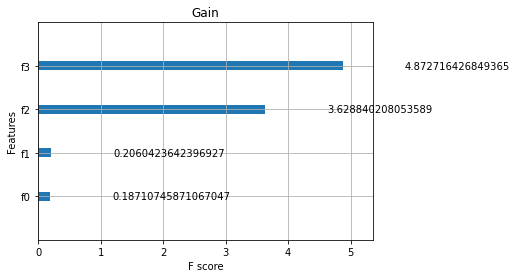

In [9]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover:** The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

<AxesSubplot:title={'center':'Cover'}, xlabel='F score', ylabel='Features'>

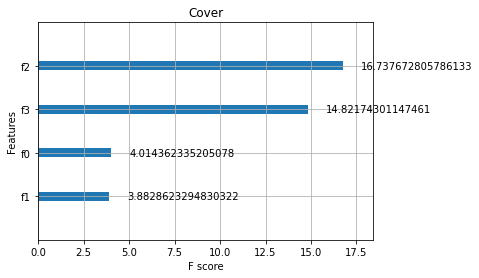

In [10]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence):** is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

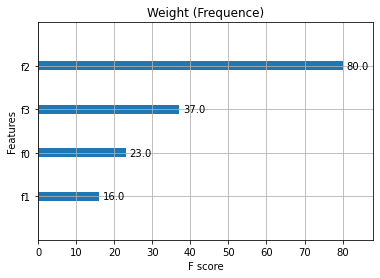

In [11]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

In order to avoid overfitting, we can use the early stopping technique looking at the error on our local validation set. Let's try it:

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [13]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

[16:05:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-merror:0.02083	validation-merror:0.00000
[2]	train-merror:0.02083	validation-merror:0.00000
[4]	train-merror:0.02083	validation-merror:0.00000
[6]	train-merror:0.01042	validation-merror:0.04167
[8]	train-merror:0.01042	validation-merror:0.04167
[10]	train-merror:0.00000	validation-merror:0.08333
[12]	train-merror:0.00000	validation-merror:0.04167
[14]	train-merror:0.00000	validation-merror:0.08333
[16]	train-merror:0.00000	validation-merror:0.08333
[18]	train-merror:0.00000	validation-merror:0.08333
[19]	train-merror:0.00000	validation-merror:0.08333


### If we plot the precision and feature weight we may see changes in the values

In [14]:
preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

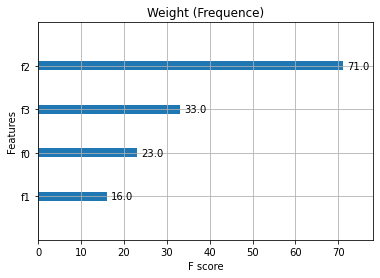

In [15]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

In [16]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.8)

ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_year, Value range: 6.00E+00 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




### Let's select the recommendations to use to train XGBoost

Several options are possible:
- Take the best recommender and select, say, the top-100 recommended items
- Take multiple recommenders and use the union of their recommendations
- ...

In this example a single model will be used to select the candidate user-item interactions to use for XGBoost

In [17]:
from Recommenders.Recommender_import_list import *

candidate_generator_recommender = ItemKNNCFRecommender(URM_train)
candidate_generator_recommender.fit()

C:\Users\ferra\anaconda3\envs\RecSysFramework38_GPU\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


ItemKNNCFRecommender: URM Detected 71 ( 0.7%) items with no interactions.
Similarity column 10681 (100.0%), 1055.50 column/sec. Elapsed time 10.12 sec


## Build the dataframe with the predictions

Creating dataframes can be quite computationally expensive. Never use "append" or iteratively concatenate new elements when you have to run a significant number of iterations, it will take forever. Initialize instead the dimension you want.

In [55]:
import pandas as pd
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np
from xgboost import XGBRanker

n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

In [56]:
training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
69873,NaN
69874,NaN
69875,NaN


In [57]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69878/69878 [00:47<00:00, 1463.08it/s]


In [58]:
training_dataframe

,ItemID
UserID,
0,"[94, 11, 175, 91, 85, 93, 74, 84, 95, 82, 26, ..."
1,"[1302, 31, 1429, 1283, 1304, 1300, 108, 37, 10..."
2,"[60, 798, 1882, 198, 296, 279, 821, 793, 284, ..."
3,"[175, 74, 75, 9, 77, 4, 1009, 84, 92, 1418, 1,..."
4,"[1073, 176, 1122, 166, 165, 44, 219, 218, 144,..."
...,...
69873,"[64, 968, 793, 864, 982, 826, 821, 1234, 62, 8..."
69874,"[466, 461, 213, 1008, 468, 259, 1093, 1147, 19..."
69875,"[148, 218, 44, 164, 170, 403, 34, 1656, 146, 4..."


### Let's transform the dataframe so that we have one recommendation per row

In [59]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,ItemID
UserID,
0,94
0,11
0,175
0,91
0,85
...,...
69877,1283
69877,1429
69877,137


### We should add the target column, which is the correct recommendation as contained in the validation data

In [60]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,8
1,0,11
2,0,12
3,1,37
4,2,22
...,...,...
1600004,69877,1646
1600005,69877,1660
1600006,69877,2001
1600007,69877,2941


In [61]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,94,left_only
1,0,11,both
2,0,175,left_only
3,0,91,left_only
4,0,85,left_only
...,...,...,...
2096335,69877,1283,left_only
2096336,69877,1429,left_only
2096337,69877,137,left_only
2096338,69877,1079,left_only


In [62]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,94,False
1,0,11,True
2,0,175,False
3,0,91,False
4,0,85,False
...,...,...,...
2096335,69877,1283,False
2096336,69877,1429,False
2096337,69877,137,False
2096338,69877,1079,False


## Now let's add some features. For example, the prediction of other algorithms

This may take some time so it is a good idea to save this data and load it instead of calculating the scores every time.

In [26]:
topPop = TopPop(URM_train)
topPop.fit()

p3alpha = P3alphaRecommender(URM_train)
p3alpha.fit()

slimbpr = SLIM_BPR_Cython(URM_train)
slimbpr.fit()


other_algorithms = {
    "TopPop": topPop,
    "P3alpha": p3alpha,
    "SLIM_BPR": slimbpr,
}


TopPopRecommender: URM Detected 71 ( 0.7%) items with no interactions.
P3alphaRecommender: URM Detected 71 ( 0.7%) items with no interactions.
P3alphaRecommender: Similarity column 10681 (100.0%), 1135.76 column/sec. Elapsed time 9.40 sec
SLIM_BPR_Recommender: URM Detected 71 ( 0.7%) items with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 69878 (100.0%) in 1.50 sec. BPR loss is 3.64E-04. Sample per second: 46456
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.59 sec
Processed 69878 (100.0%) in 1.05 sec. BPR loss is 1.13E-03. Sample per second: 66575
SLIM_BPR_Recommender: Epoch 2 of 300. Elapsed time 1.13 sec
Processed 69878 (100.0%) in 0.56 sec. BPR loss is 1.94E-03. Sample per second: 124319
SLIM_BPR_Recommender: Epoch 3 of 300. Elapsed time 1.64 sec
Processed 69878 (100.0%) in 1.0

SLIM_BPR_Recommender: Epoch 53 of 300. Elapsed time 28.10 sec
Processed 69878 (100.0%) in 0.51 sec. BPR loss is 4.11E-02. Sample per second: 138037
SLIM_BPR_Recommender: Epoch 54 of 300. Elapsed time 28.59 sec
Processed 69878 (100.0%) in 0.97 sec. BPR loss is 4.15E-02. Sample per second: 71836
SLIM_BPR_Recommender: Epoch 55 of 300. Elapsed time 29.05 sec
Processed 69878 (100.0%) in 1.43 sec. BPR loss is 4.29E-02. Sample per second: 48754
SLIM_BPR_Recommender: Epoch 56 of 300. Elapsed time 29.52 sec
Processed 69878 (100.0%) in 0.92 sec. BPR loss is 4.34E-02. Sample per second: 76137
SLIM_BPR_Recommender: Epoch 57 of 300. Elapsed time 30.00 sec
Processed 69878 (100.0%) in 1.41 sec. BPR loss is 4.47E-02. Sample per second: 49478
SLIM_BPR_Recommender: Epoch 58 of 300. Elapsed time 30.49 sec
Processed 69878 (100.0%) in 0.89 sec. BPR loss is 4.50E-02. Sample per second: 78269
SLIM_BPR_Recommender: Epoch 59 of 300. Elapsed time 30.98 sec
Processed 69878 (100.0%) in 1.39 sec. BPR loss is 4.56E

SLIM_BPR_Recommender: Epoch 109 of 300. Elapsed time 54.43 sec
Processed 69878 (100.0%) in 0.80 sec. BPR loss is 8.06E-02. Sample per second: 86824
SLIM_BPR_Recommender: Epoch 110 of 300. Elapsed time 54.89 sec
Processed 69878 (100.0%) in 1.29 sec. BPR loss is 8.26E-02. Sample per second: 54114
SLIM_BPR_Recommender: Epoch 111 of 300. Elapsed time 55.37 sec
Processed 69878 (100.0%) in 0.76 sec. BPR loss is 8.36E-02. Sample per second: 91602
SLIM_BPR_Recommender: Epoch 112 of 300. Elapsed time 55.84 sec
Processed 69878 (100.0%) in 1.24 sec. BPR loss is 8.26E-02. Sample per second: 56292
SLIM_BPR_Recommender: Epoch 113 of 300. Elapsed time 56.32 sec
Processed 69878 (100.0%) in 0.71 sec. BPR loss is 8.51E-02. Sample per second: 97889
SLIM_BPR_Recommender: Epoch 114 of 300. Elapsed time 56.80 sec
Processed 69878 (100.0%) in 1.20 sec. BPR loss is 8.42E-02. Sample per second: 58360
SLIM_BPR_Recommender: Epoch 115 of 300. Elapsed time 57.28 sec
Processed 69878 (100.0%) in 0.71 sec. BPR loss is

SLIM_BPR_Recommender: Epoch 165 of 300. Elapsed time 1.35 min
Processed 69878 (100.0%) in 1.16 sec. BPR loss is 1.18E-01. Sample per second: 60254
SLIM_BPR_Recommender: Epoch 166 of 300. Elapsed time 1.35 min
Processed 69878 (100.0%) in 0.70 sec. BPR loss is 1.20E-01. Sample per second: 100370
SLIM_BPR_Recommender: Epoch 167 of 300. Elapsed time 1.36 min
Processed 69878 (100.0%) in 1.21 sec. BPR loss is 1.22E-01. Sample per second: 57766
SLIM_BPR_Recommender: Epoch 168 of 300. Elapsed time 1.37 min
Processed 69878 (100.0%) in 0.68 sec. BPR loss is 1.21E-01. Sample per second: 102733
SLIM_BPR_Recommender: Epoch 169 of 300. Elapsed time 1.38 min
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 1.22E-01. Sample per second: 58737
SLIM_BPR_Recommender: Epoch 170 of 300. Elapsed time 1.39 min
Processed 69878 (100.0%) in 0.68 sec. BPR loss is 1.23E-01. Sample per second: 101989
SLIM_BPR_Recommender: Epoch 171 of 300. Elapsed time 1.40 min
Processed 69878 (100.0%) in 1.14 sec. BPR loss is 1.2

SLIM_BPR_Recommender: Epoch 221 of 300. Elapsed time 1.79 min
Processed 69878 (100.0%) in 0.88 sec. BPR loss is 1.57E-01. Sample per second: 79341
SLIM_BPR_Recommender: Epoch 222 of 300. Elapsed time 1.80 min
Processed 69878 (100.0%) in 1.35 sec. BPR loss is 1.58E-01. Sample per second: 51714
SLIM_BPR_Recommender: Epoch 223 of 300. Elapsed time 1.81 min
Processed 69878 (100.0%) in 0.82 sec. BPR loss is 1.57E-01. Sample per second: 85449
SLIM_BPR_Recommender: Epoch 224 of 300. Elapsed time 1.81 min
Processed 69878 (100.0%) in 1.28 sec. BPR loss is 1.58E-01. Sample per second: 54409
SLIM_BPR_Recommender: Epoch 225 of 300. Elapsed time 1.82 min
Processed 69878 (100.0%) in 0.74 sec. BPR loss is 1.59E-01. Sample per second: 94324
SLIM_BPR_Recommender: Epoch 226 of 300. Elapsed time 1.83 min
Processed 69878 (100.0%) in 1.20 sec. BPR loss is 1.59E-01. Sample per second: 58214
SLIM_BPR_Recommender: Epoch 227 of 300. Elapsed time 1.84 min
Processed 69878 (100.0%) in 0.66 sec. BPR loss is 1.59E-

SLIM_BPR_Recommender: Epoch 277 of 300. Elapsed time 2.23 min
Processed 69878 (100.0%) in 1.17 sec. BPR loss is 1.91E-01. Sample per second: 59701
SLIM_BPR_Recommender: Epoch 278 of 300. Elapsed time 2.24 min
Processed 69878 (100.0%) in 0.63 sec. BPR loss is 1.91E-01. Sample per second: 111804
SLIM_BPR_Recommender: Epoch 279 of 300. Elapsed time 2.25 min
Processed 69878 (100.0%) in 1.10 sec. BPR loss is 1.92E-01. Sample per second: 63726
SLIM_BPR_Recommender: Epoch 280 of 300. Elapsed time 2.25 min
Processed 69878 (100.0%) in 0.56 sec. BPR loss is 1.91E-01. Sample per second: 124994
SLIM_BPR_Recommender: Epoch 281 of 300. Elapsed time 2.26 min
Processed 69878 (100.0%) in 1.01 sec. BPR loss is 1.93E-01. Sample per second: 68806
SLIM_BPR_Recommender: Epoch 282 of 300. Elapsed time 2.27 min
Processed 69878 (100.0%) in 0.48 sec. BPR loss is 1.95E-01. Sample per second: 145849
SLIM_BPR_Recommender: Epoch 283 of 300. Elapsed time 2.28 min
Processed 69878 (100.0%) in 0.94 sec. BPR loss is 1.9

In [63]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(1000)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.00it/s]


,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR
0,0,94,False,12852.0,0.247975,1.474523
1,0,11,True,15175.0,0.258862,1.447398
2,0,175,False,18545.0,0.362272,1.659632
3,0,91,False,12191.0,0.225694,1.375875
4,0,85,False,16215.0,0.264557,1.551579
...,...,...,...,...,...,...
2096335,69877,1283,False,NaN,NaN,NaN
2096336,69877,1429,False,NaN,NaN,NaN
2096337,69877,137,False,NaN,NaN,NaN
2096338,69877,1079,False,NaN,NaN,NaN


## The popularity of the item, the user activity etc..

In [64]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity
0,0,94,False,12852.0,0.247975,1.474523,12852
1,0,11,True,15175.0,0.258862,1.447398,15175
2,0,175,False,18545.0,0.362272,1.659632,18545
3,0,91,False,12191.0,0.225694,1.375875,12191
4,0,85,False,16215.0,0.264557,1.551579,16215
...,...,...,...,...,...,...,...
2096335,69877,1283,False,NaN,NaN,NaN,8640
2096336,69877,1429,False,NaN,NaN,NaN,5472
2096337,69877,137,False,NaN,NaN,NaN,9852
2096338,69877,1079,False,NaN,NaN,NaN,4782


## Or the profile length

In [65]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len
0,0,94,False,12852.0,0.247975,1.474523,12852,13
1,0,11,True,15175.0,0.258862,1.447398,15175,13
2,0,175,False,18545.0,0.362272,1.659632,18545,13
3,0,91,False,12191.0,0.225694,1.375875,12191,13
4,0,85,False,16215.0,0.264557,1.551579,16215,13
...,...,...,...,...,...,...,...,...
2096335,69877,1283,False,NaN,NaN,NaN,8640,32
2096336,69877,1429,False,NaN,NaN,NaN,5472,32
2096337,69877,137,False,NaN,NaN,NaN,9852,32
2096338,69877,1079,False,NaN,NaN,NaN,4782,32


## The same can be done with item features

It is better in this case to first create a sparse matrix replicating the rows needed and ten transform it into a sparse dataframe

**WARNING** dataframes are not sparse structures and this may cause the memory requirements to explode

In [66]:
features_df = pd.DataFrame.sparse.from_spmatrix(ICM_genres)
features_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10677,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})
training_dataframe

,UserID,Label,TopPop,P3alpha,SLIM_BPR,item_popularity,user_profile_len,0,1,2,...,10,11,12,13,14,15,16,17,18,19
0,11472,False,NaN,NaN,NaN,1577,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,33681,False,NaN,NaN,NaN,1577,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,39053,False,NaN,NaN,NaN,1577,19,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,56423,False,NaN,NaN,NaN,1577,11,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,67765,True,NaN,NaN,NaN,1577,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9718,26787,False,NaN,NaN,NaN,9,20,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9718,60873,False,NaN,NaN,NaN,9,38,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9917,60529,False,NaN,NaN,NaN,12,22,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10024,11660,False,NaN,NaN,NaN,10,18,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [74]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

### To use the ranker one first needs to specify the size of the groups, a group is the dimension you rank on, in this case each group corresponds to a user. Since we have generated a fixed number of candidates for each user (30) all groups have the same length.

In [77]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [78]:
from xgboost import XGBRanker

In [79]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [80]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=False, eval_metric=None, feature_types=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
          max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=50, n_jobs=0,
          num_parallel_tree=1, predictor='auto', random_state=0, ...)

### Once the model is trained we can use it to compute predictions. Each prediction will refer to a specific user-item pair, which we will ten need to rank as we do in any other recommender model.

### Important: In order to use this model to predict the score of new datapoints (i.e., new recommendations) we have to repeat the same data processing steps but:
- We do not need a train-label split, we can user all the data we have to compute the predictions and the features
- The recommendation models used to generate the scores should be trained on all the available data

In [81]:
XGB_model.predict(X_train)

array([0.20504402, 0.6008499 , 0.08450495, ..., 0.9010154 , 0.97065383,
       0.49457154], dtype=float32)

### We can have a look to the feature importance to assess which are the most informative ones

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

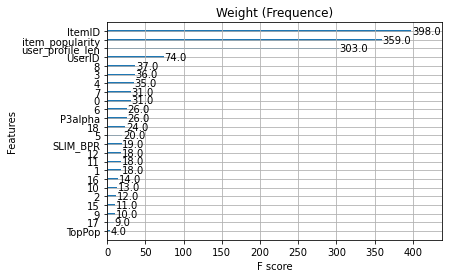

In [82]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

### Note, here ItemID and UserID are provided as integers, meaning that XGBoost will use them as any integer number and may split user groups according to whether their ID is < or > of a certain value. This makes no sense of course because the IDs are not ordinal, they are categorical and the specific numerical value of an IDs has no relation with the semantics of the problem. 

How to address this? 
- Use one-hot-encoded values -> drawback, the number of columns becomes very large
- Use the native "Categorical" data type -> drawback, it is still experimental and may not work very well
- Use another representation of the IDs, such as target encoding -> drawback, some further processing is needed and no teaching material is provided on this

### How to perform hyperparameter tuning?
The issue with this method is that you need a label which should be an item the user has not interacted with but that is a correct recommendation. In practice the idea is:
- Split the data in the usual training-validation-test
- Split the training data in two: one part you use to train the recommenders and another you use as the hidden Label to train XGBoost
- Evaluate your predictions on the validation data as you did for any other recommender model. Use this to select the optimal hyperparameters.
- Given the selected hyperparameters, train the recommender models on all the available data and use all the available data to compute the features used by XGBoost.

Challenge: Since the label we use for training XGBoost is the split of a split, it may happen that the actual correct recommendations are very few. This will result in a problem that is very unbalanced towards zero and will make the training difficult and the evaluation noisy. To mitigate this you may use k-fold cross validation and define the valdation result of a certain hyperparameter configuration as the average obtained with k different training-label splits.